### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Load the Data

In [2]:
df = pd.read_csv('quarterbacks.csv')

df.head()

,player,team,week,year,passingYards,passingTouchdowns,interceptions,rushingYards,rushingTouchdowns,completions,passingAttempts,fumblesLost,fantasy_points,next_week_fantasy_points
0,Aaron Rodgers,Green Bay Packers,1,2020,364.0,4.0,0.0,2.0,0.0,32,44,0.0,30.76,19.20
1,Baker Mayfield,Cleveland Browns,1,2020,189.0,1.0,1.0,3.0,0.0,21,39,0.0,9.86,15.26
2,Ben Roethlisberger,Pittsburgh Steelers,1,2020,229.0,3.0,0.0,9.0,0.0,21,32,0.0,22.06,18.24
3,Cam Newton,New England Patriots,1,2020,155.0,0.0,0.0,75.0,2.0,15,19,0.0,25.70,34.58
4,Carson Wentz,Philadelphia Eagles,1,2020,270.0,2.0,2.0,2.0,0.0,24,42,1.0,15.00,12.38


### Add Fantasy Points to DF

In [3]:
df.head()

,player,team,week,year,passingYards,passingTouchdowns,interceptions,rushingYards,rushingTouchdowns,completions,passingAttempts,fumblesLost,fantasy_points,next_week_fantasy_points
0,Aaron Rodgers,Green Bay Packers,1,2020,364.0,4.0,0.0,2.0,0.0,32,44,0.0,30.76,19.20
1,Baker Mayfield,Cleveland Browns,1,2020,189.0,1.0,1.0,3.0,0.0,21,39,0.0,9.86,15.26
2,Ben Roethlisberger,Pittsburgh Steelers,1,2020,229.0,3.0,0.0,9.0,0.0,21,32,0.0,22.06,18.24
3,Cam Newton,New England Patriots,1,2020,155.0,0.0,0.0,75.0,2.0,15,19,0.0,25.70,34.58
4,Carson Wentz,Philadelphia Eagles,1,2020,270.0,2.0,2.0,2.0,0.0,24,42,1.0,15.00,12.38


In [4]:
# points_per_passing_yard = 0.04
# points_per_passing_td = 4
# points_per_interception = -2
# points_per_rushing_yard = 0.1
# points_per_rushing_td = 6
# points_per_reception = 1
# points_per_receiving_yard = 0.1
# points_per_receiving_td = 6
# points_per_fumble = -2

# def get_player_points(row):
#     points = 0
#     points += row['passingYards'] * points_per_passing_yard
#     points += row['passingTouchdowns'] * points_per_passing_td
#     points += row['interceptions'] * points_per_interception
#     points += row['rushingYards'] * points_per_rushing_yard
#     points += row['rushingTouchdowns'] * points_per_rushing_td
#     # points += row[''] * points_per_reception
#     # points += row[''] * points_per_receiving_yard
#     # points += row[''] * points_per_receiving_td
#     points += row['fumblesLost'] * points_per_fumble

#     return points

# df['Fantasy Points'] = df.apply(get_player_points, axis=1)

# df.head()

### EDA

<Axes: >

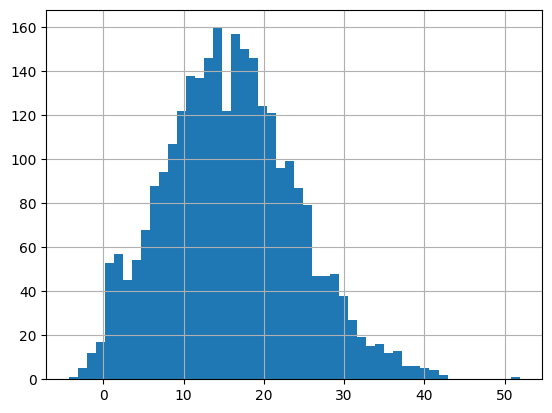

In [5]:
# look at the distribution of points
df['fantasy_points'].hist(bins=50)

In [6]:
df['fantasy_points'].describe()

count    2791.000000
mean       15.886306
std         8.259935
min        -4.320000
25%        10.100000
50%        15.580000
75%        21.220000
max        51.880000
Name: fantasy_points, dtype: float64

Let's look at some of our features against the target variable

In [7]:
# drop rows from the dataframe that have Nan values in the target column
print(df.shape)
df = df.dropna(subset=['next_week_fantasy_points'])
print(df.shape)

(2791, 14)
(2791, 14)


In [8]:
qb = df.copy()

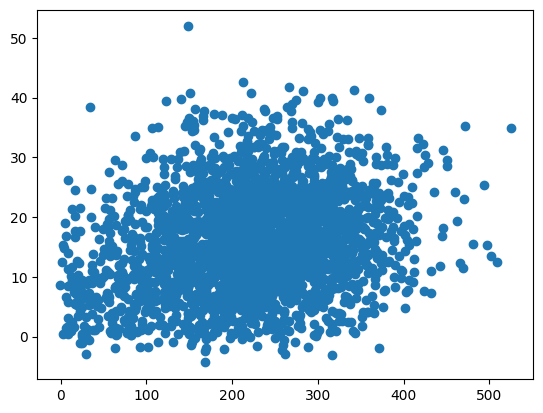

In [9]:
# plot passing yards vs fantasy points
plt.scatter(qb['passingYards'], qb['next_week_fantasy_points'])

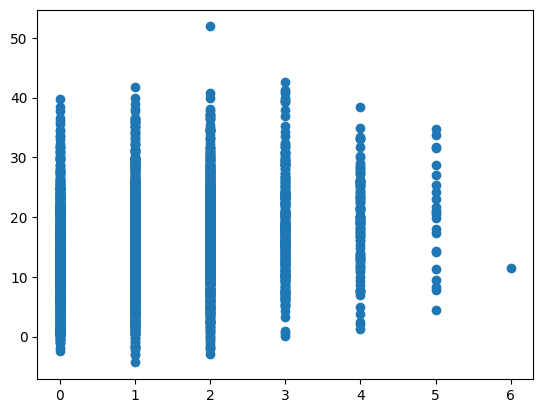

In [10]:
plt.scatter(qb['passingTouchdowns'], qb['next_week_fantasy_points'])

### Create a Model

the following code will create a model for the qbs, however this could be applied to any of the positions

In [11]:
qb.head()

,player,team,week,year,passingYards,passingTouchdowns,interceptions,rushingYards,rushingTouchdowns,completions,passingAttempts,fumblesLost,fantasy_points,next_week_fantasy_points
0,Aaron Rodgers,Green Bay Packers,1,2020,364.0,4.0,0.0,2.0,0.0,32,44,0.0,30.76,19.20
1,Baker Mayfield,Cleveland Browns,1,2020,189.0,1.0,1.0,3.0,0.0,21,39,0.0,9.86,15.26
2,Ben Roethlisberger,Pittsburgh Steelers,1,2020,229.0,3.0,0.0,9.0,0.0,21,32,0.0,22.06,18.24
3,Cam Newton,New England Patriots,1,2020,155.0,0.0,0.0,75.0,2.0,15,19,0.0,25.70,34.58
4,Carson Wentz,Philadelphia Eagles,1,2020,270.0,2.0,2.0,2.0,0.0,24,42,1.0,15.00,12.38


In [12]:
print(qb.shape)

(2791, 14)


In [13]:
# we only want to keep columns that are going to be used as features in our model...  
# so we drop the columns that are not going to be used
qb = qb[['passingYards', 'passingTouchdowns', 'interceptions', 'rushingYards', 'rushingTouchdowns', 'completions', 'passingAttempts', 'fumblesLost', 'next_week_fantasy_points']]

qb.head()

,passingYards,passingTouchdowns,interceptions,rushingYards,rushingTouchdowns,completions,passingAttempts,fumblesLost,next_week_fantasy_points
0,364.0,4.0,0.0,2.0,0.0,32,44,0.0,19.20
1,189.0,1.0,1.0,3.0,0.0,21,39,0.0,15.26
2,229.0,3.0,0.0,9.0,0.0,21,32,0.0,18.24
3,155.0,0.0,0.0,75.0,2.0,15,19,0.0,34.58
4,270.0,2.0,2.0,2.0,0.0,24,42,1.0,12.38


In [14]:
X = qb.drop('next_week_fantasy_points', axis=1)
y = qb[['next_week_fantasy_points']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=123)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# evaluate on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.2f' % mse)

MSE: 76.77


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

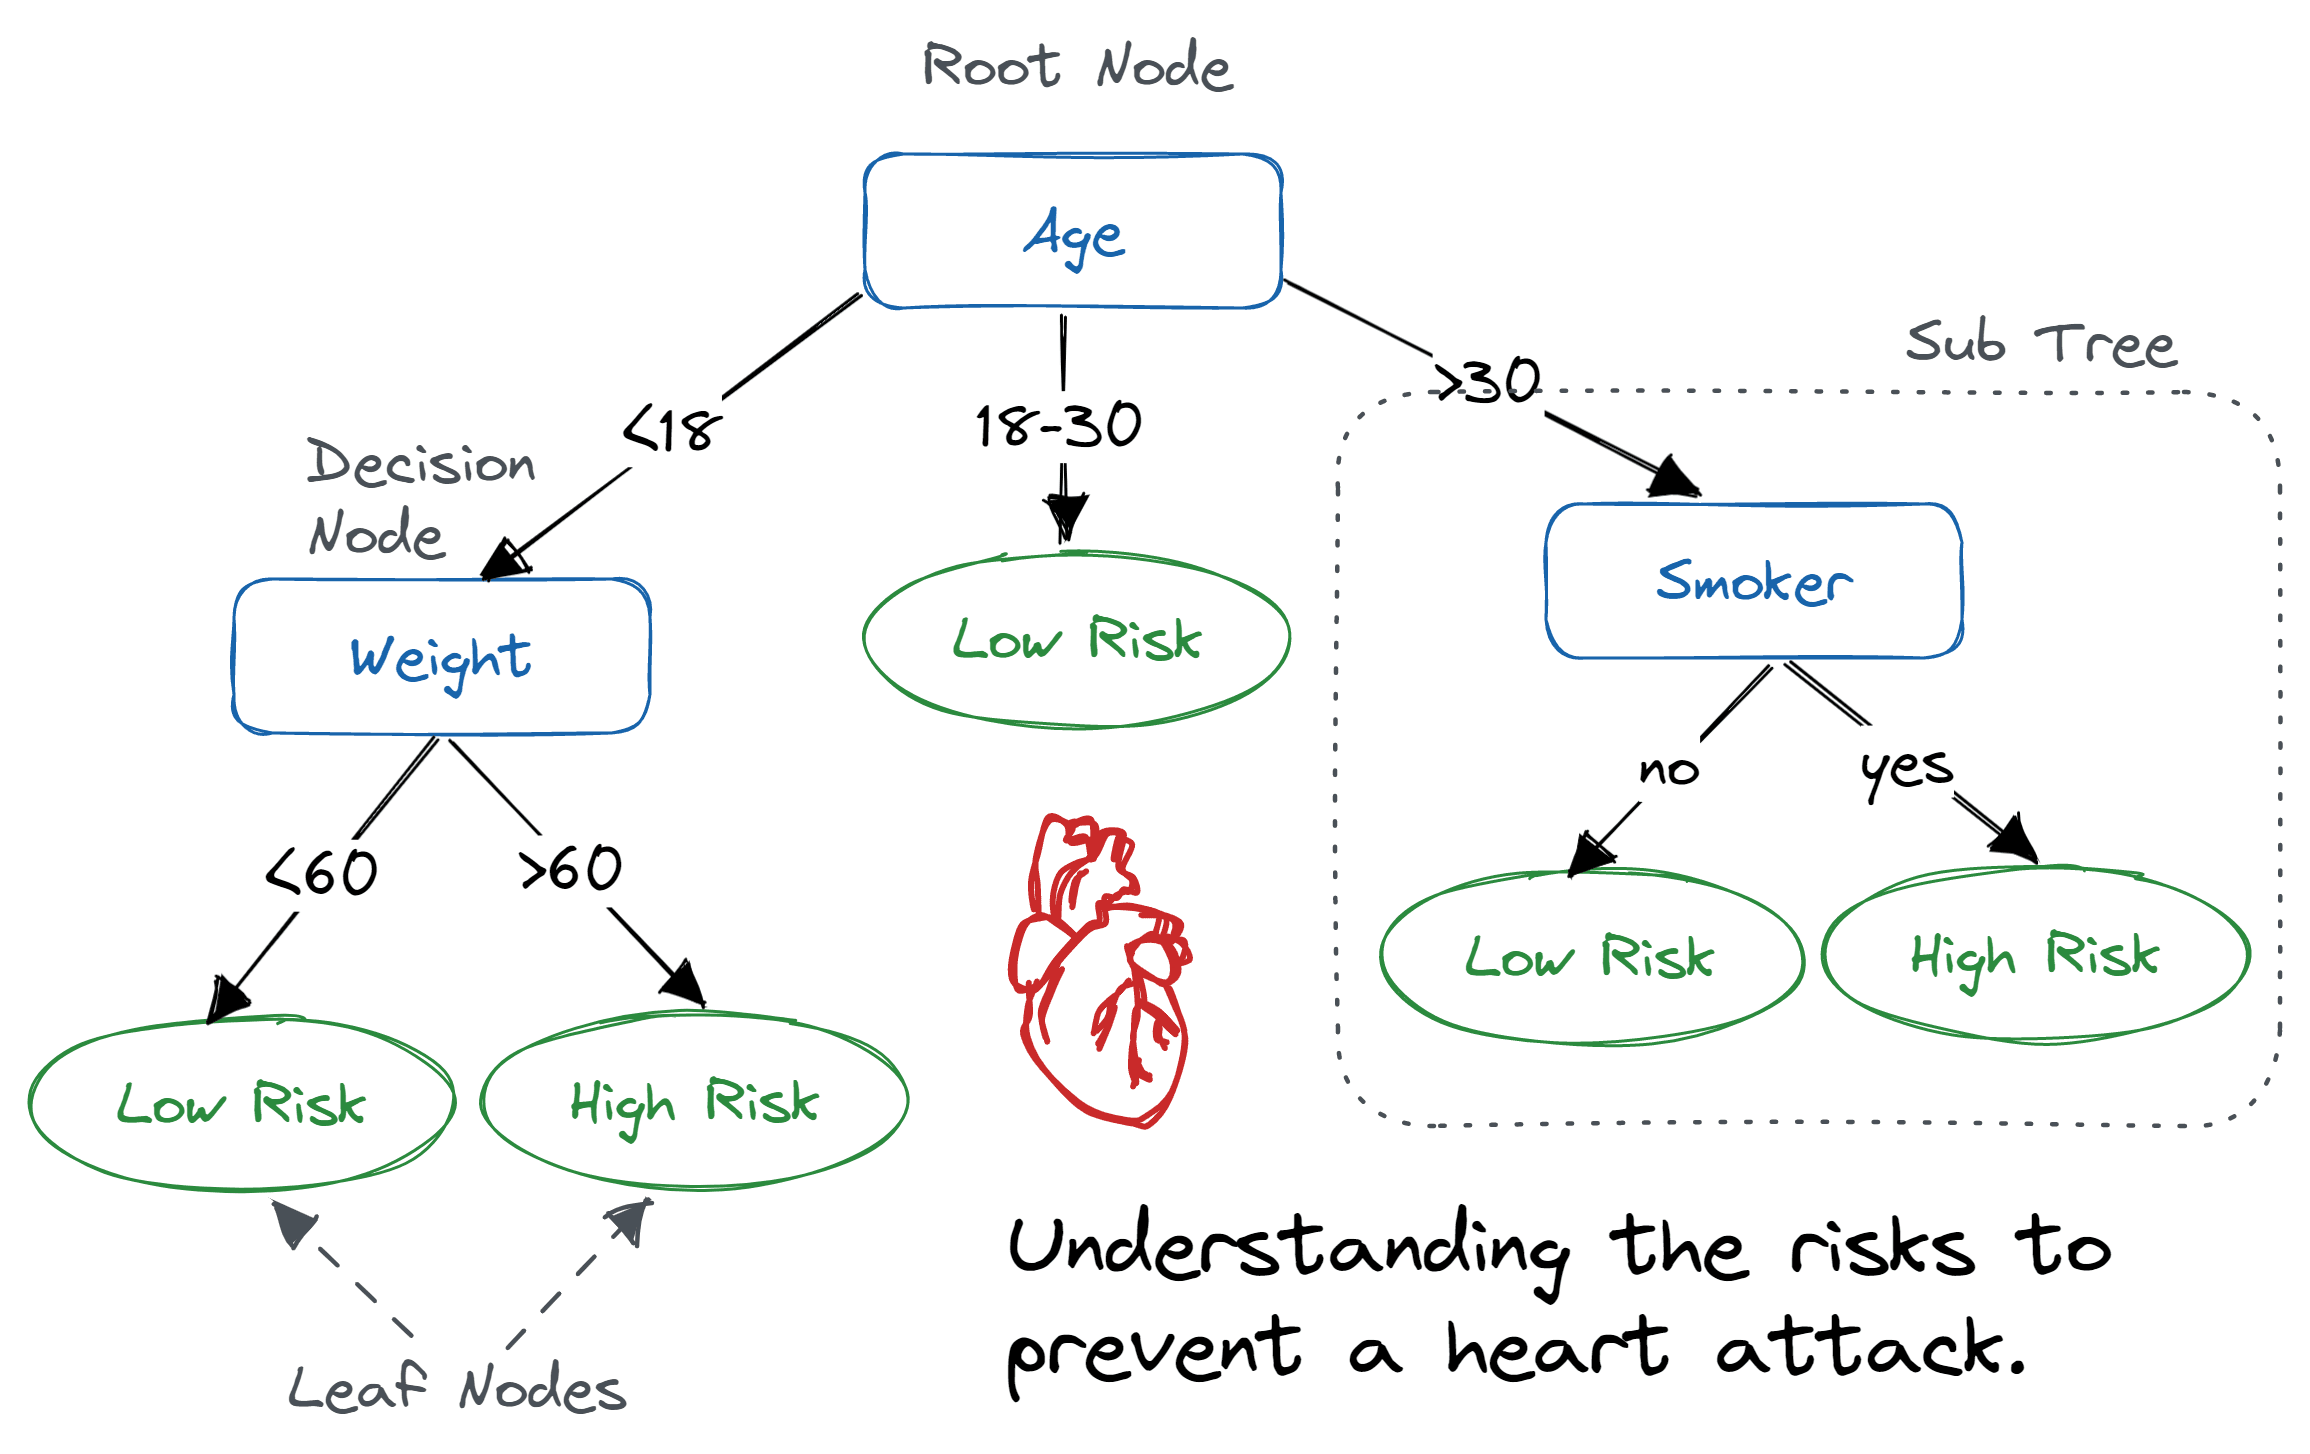

In [18]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

class BayesianXGBOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        # Define hyperparameter bounds
        self.pbounds = {
            'max_depth': (3, 12),            # Tree depth
            'learning_rate': (0.01, 0.3),    # Learning rate
            'n_estimators': (100, 1000),     # Number of trees
            'min_child_weight': (1, 7),      # Minimum sum of instance weight in a child
            'gamma': (0, 0.5),               # Minimum loss reduction for partition
            'subsample': (0.6, 1.0),         # Subsample ratio of training instances
            'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns for each tree
        }
        
    def xgb_evaluate(self, max_depth, learning_rate, n_estimators, 
                    min_child_weight, gamma, subsample, colsample_bytree):
        """Evaluation function for Bayesian optimization"""
        params = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'objective': 'reg:squarederror',
            'random_state': 42
        }
        
        model = model = xgb.XGBRegressor(**params)
        model.fit(self.X_train, self.y_train)
        predictions = model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, predictions)
        
        # Return negative MSE because Bayesian optimization maximizes
        return -mse
    
    def optimize(self, n_iter=50, init_points=5):
        """Run Bayesian optimization"""
        optimizer = BayesianOptimization(
            f=self.xgb_evaluate,
            pbounds=self.pbounds,
            random_state=42
        )
        
        optimizer.maximize(
            init_points=init_points,  # Number of initial random evaluations
            n_iter=n_iter             # Number of optimization iterations
        )
        
        # Get best parameters
        params = optimizer.max['params']
        params['max_depth'] = int(params['max_depth'])
        params['n_estimators'] = int(params['n_estimators'])
        
        # Train final model with best parameters
        final_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            **params
        )
        final_model.fit(self.X_train, self.y_train)
        
        return {
            'best_params': params,
            'best_score': -optimizer.max['target'],  # Convert back to MSE
            'model': final_model,
            'optimization_history': optimizer.space.target
        }
    
optimizer = BayesianXGBOptimizer(X_train, X_val, y_train, y_val)
result = optimizer.optimize(n_iter=50, init_points=5)

print('Best score: %.2f' % result['best_score'])
print('Best parameters:', result['best_params'])

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -79.45    | 0.7498    | 0.4754    | 0.2223    | 8.388     | 1.936     | 240.4     | 0.6232    |
| 2         | -78.38    | 0.9465    | 0.3006    | 0.2153    | 3.185     | 6.819     | 849.2     | 0.6849    |
| 3         | -73.41    | 0.6727    | 0.0917    | 0.09823   | 7.723     | 3.592     | 362.1     | 0.8447    |
| 4         | -72.55    | 0.6558    | 0.1461    | 0.1162    | 7.105     | 5.711     | 279.7     | 0.8057    |
| 5         | -81.61    | 0.837     | 0.02323   | 0.1862    | 4.535     | 1.39      | 954.0     | 0.9863    |
| 6         | -87.02    | 0.7182    | 0.4059    | 0.277     | 6.711     | 6.333     | 279.0     | 0.6886    |
| 7         | -86.2     | 0.6257    | 0.05448   | 0.27      | 10.65     | 5.511     | 351.0     | 0.7991    |
| 8       

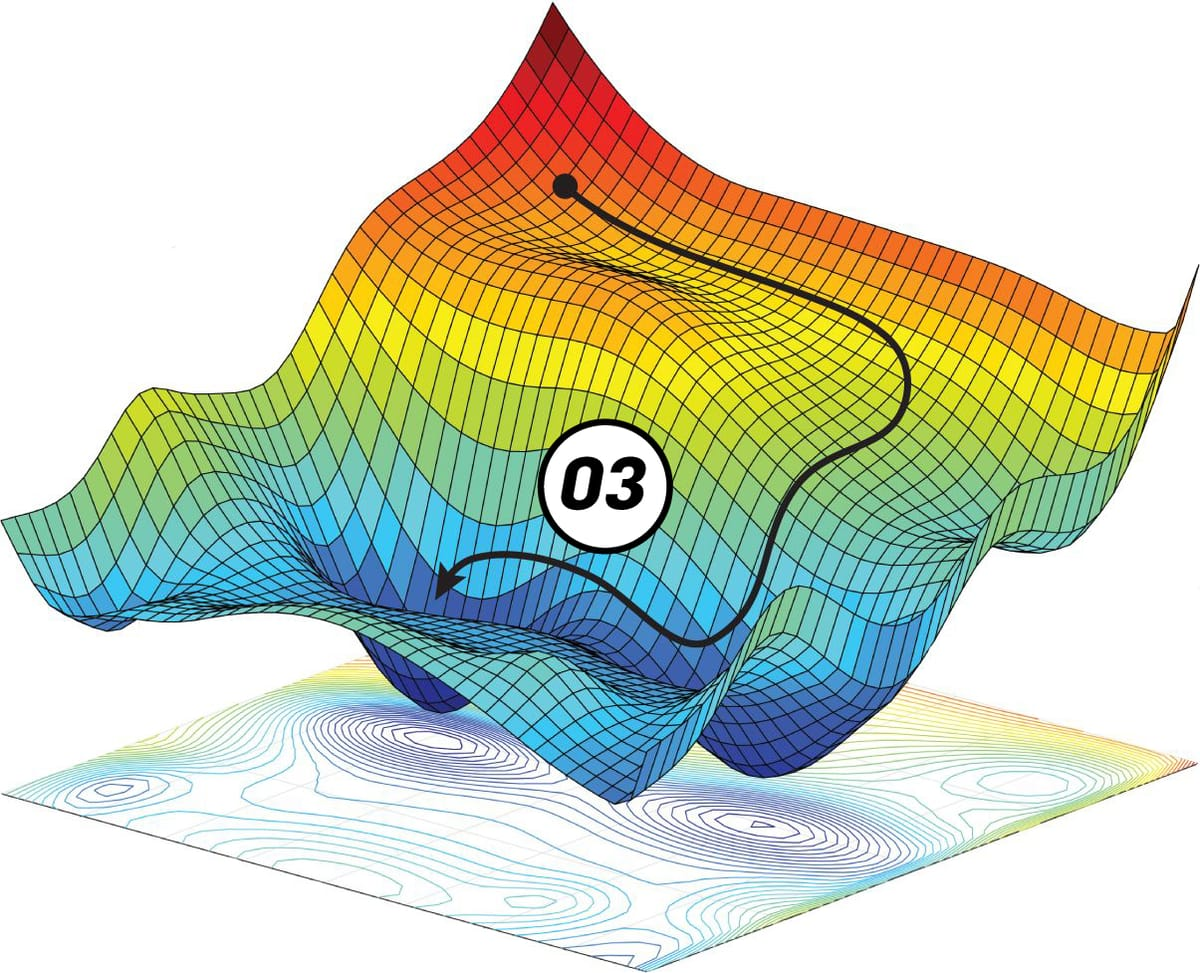

In [19]:
# recreate the model with the best parameters
model = result['model']

# evaluate on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.2f' % mse)

MSE: 64.61


### Look at some of the predictions and compare to actual values

In [20]:
X_test.head()

,passingYards,passingTouchdowns,interceptions,rushingYards,rushingTouchdowns,completions,passingAttempts,fumblesLost
1463,54.0,0.0,0.0,0.0,0.0,5,7,0.0
357,307.0,3.0,0.0,19.0,0.0,34,45,1.0
2740,158.0,2.0,0.0,68.0,1.0,17,26,0.0
630,172.0,3.0,1.0,7.0,0.0,14,18,0.0
1854,264.0,0.0,1.0,12.0,0.0,23,34,0.0


In [21]:
# predict the next week fantasy points for the first 5 rows in the test set
predictions = model.predict(X_test.head())

In [22]:
# show the actual next week fantasy points for the first 5 rows in the test set
temp_df = y_test.head()
temp_df['predictions'] = predictions
temp_df['percent_difference'] = (temp_df['next_week_fantasy_points'] - temp_df['predictions']) / temp_df['next_week_fantasy_points']
temp_df

C:\Users\ruppea\AppData\Local\Temp\ipykernel_10800\3744122504.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['predictions'] = predictions
C:\Users\ruppea\AppData\Local\Temp\ipykernel_10800\3744122504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['percent_difference'] = (temp_df['next_week_fantasy_points'] - temp_df['predictions']) / temp_df['next_week_fantasy_points']


,next_week_fantasy_points,predictions,percent_difference
1463,6.28,8.608759,-0.370821
357,23.40,19.263353,0.176780
2740,16.92,23.217560,-0.372196
630,22.32,16.835260,0.245732
1854,1.04,16.546961,-14.910539
